In [19]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [20]:
train_dir=r'C:\Users\TEJASWI\OneDrive\Documents\Deep Learning Projects\Android-App-Skin-Cancer-Detector\Training\Train'

In [21]:
Labels = ['Benign', 'Malignant']

In [22]:
print ("class : ")
for i in range(len(Labels)):
    print (i, end = " ")
    print (Labels[i])

class : 
0 Benign
1 Malignant


In [23]:
print('Number of classes:',len(Labels))

Number of classes: 2


In [24]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16

In [25]:
IMAGE_SIZE

(224, 224)

In [26]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 24 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [27]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE]  )


In [28]:
do_fine_tuning = False
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True

else:
  feature_extractor.trainable = False

In [29]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define the input shape for your images
input_shape = (224, 224, 3)  # Adjust according to your image size

# Load the ResNet50 model as a feature extractor (excluding the top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Fine-tune some top layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Create the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.5),
    Dense(train_generator.num_classes, activation='softmax',
          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])




# Print the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               51380736  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 74,969,474
Trainable params: 74,916,354
Non-trainable params: 53,120
_________________________________________________________________


In [30]:
# Compile the model with a lower initial learning rate
LEARNING_RATE = 0.0001
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Implement learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_schedule = LearningRateScheduler(lr_scheduler)

In [ ]:
EPOCHS = 6
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        callbacks=[early_stopping, lr_schedule])

ValueError: x and y must have same first dimension, but have shapes (10,) and (6,)

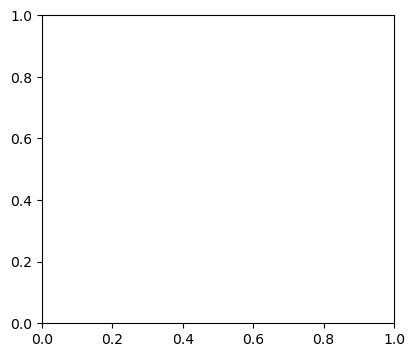

In [18]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

1/1 [==============================] - 1s 1s/step
class: Malignant, confidence: 0.543727


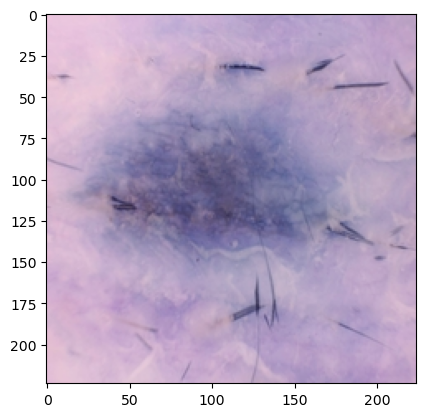

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 210ms/step
class: Malignant, confidence: 0.549806


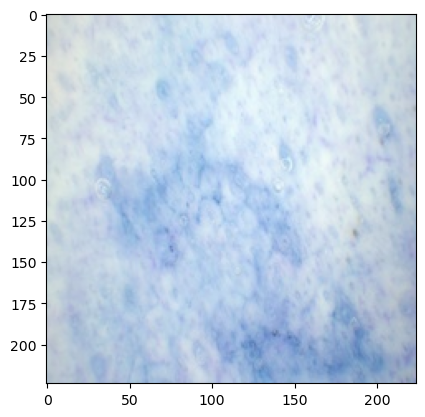

1/1 [==============================] - 0s 368ms/step
class: Malignant, confidence: 0.548198


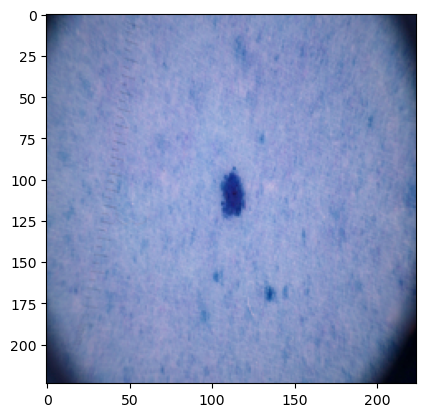

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 335ms/step
class: Malignant, confidence: 0.534562


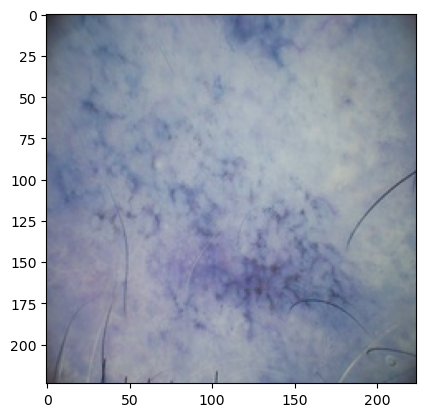

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 307ms/step
class: Malignant, confidence: 0.571335


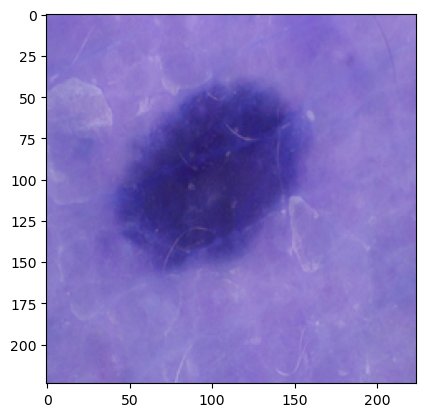

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 317ms/step
class: Malignant, confidence: 0.555913


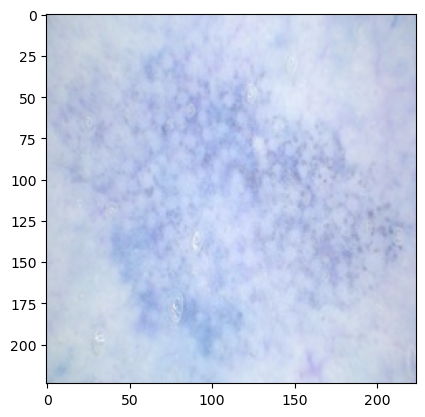

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 283ms/step
class: Malignant, confidence: 0.590234


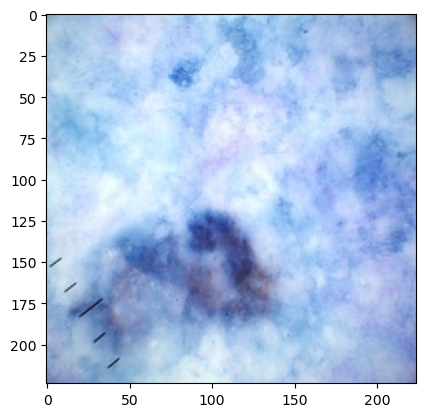

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 309ms/step
class: Malignant, confidence: 0.551859


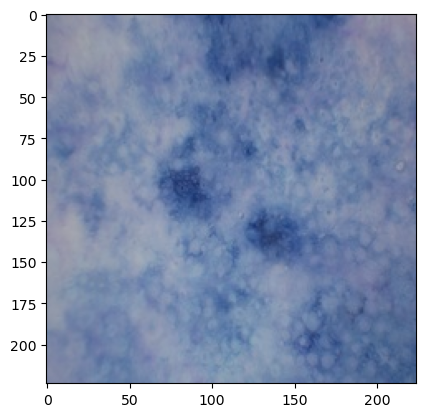

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 294ms/step
class: Malignant, confidence: 0.559145


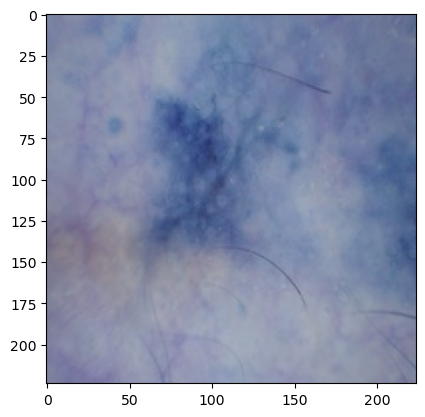

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 217ms/step
class: Malignant, confidence: 0.565608


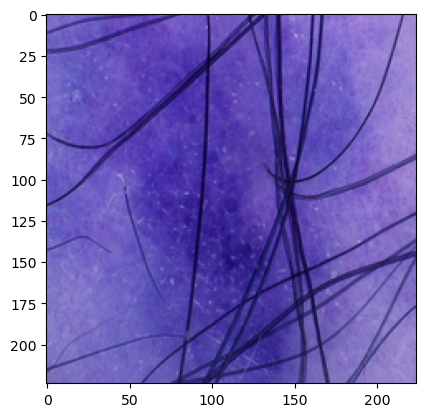

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 184ms/step
class: Malignant, confidence: 0.562286


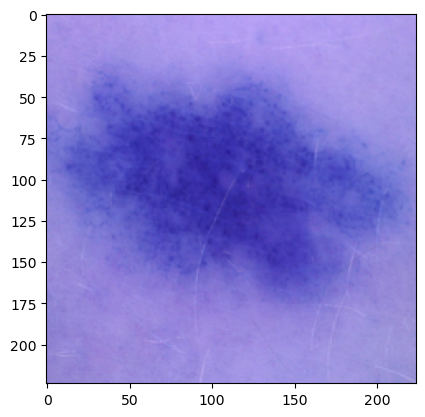

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 200ms/step
class: Malignant, confidence: 0.559989


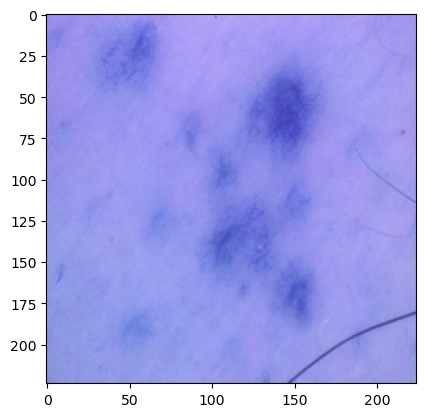

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 221ms/step
class: Malignant, confidence: 0.546398


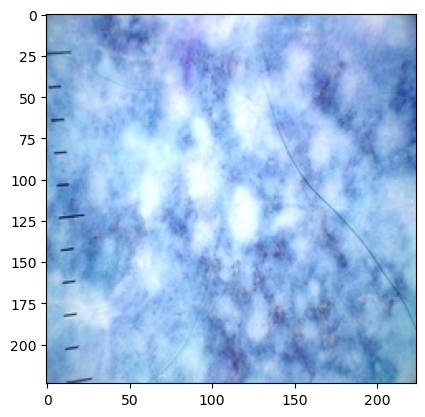

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 275ms/step
class: Malignant, confidence: 0.556060


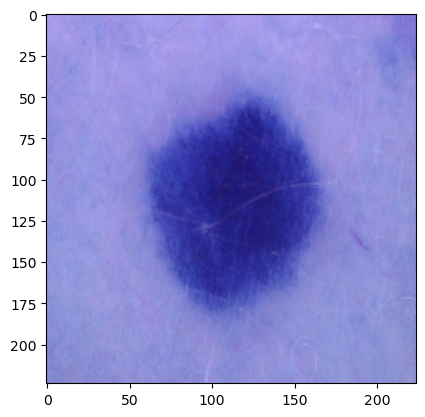

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 233ms/step
class: Malignant, confidence: 0.568123


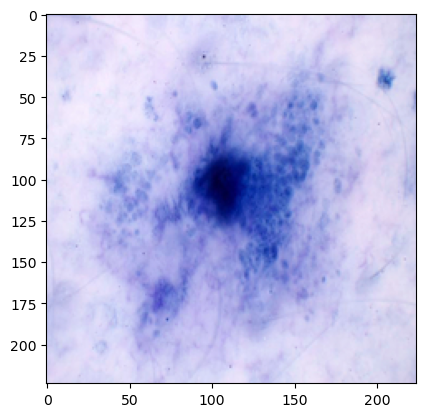

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 198ms/step
class: Malignant, confidence: 0.545791


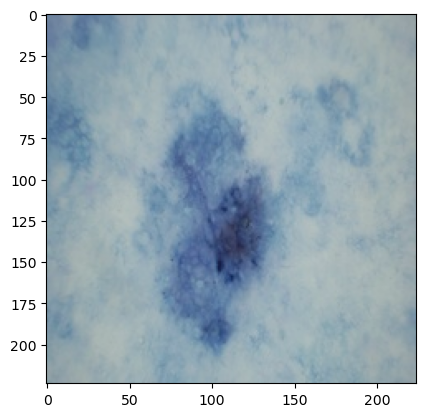

<Figure size 640x480 with 0 Axes>

In [74]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255

    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)

    return {Labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):


    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

In [75]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

1/1 [==============================] - 2s 2s/step
Classification Report
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00         8
   malignant       0.50      1.00      0.67         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



C:\Users\TEJASWI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TEJASWI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TEJASWI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 2s 2s/step - loss: 0.7152 - accuracy: 0.5000
[0.715203583240509, 0.5]


Confusion Matrix


<Axes: >

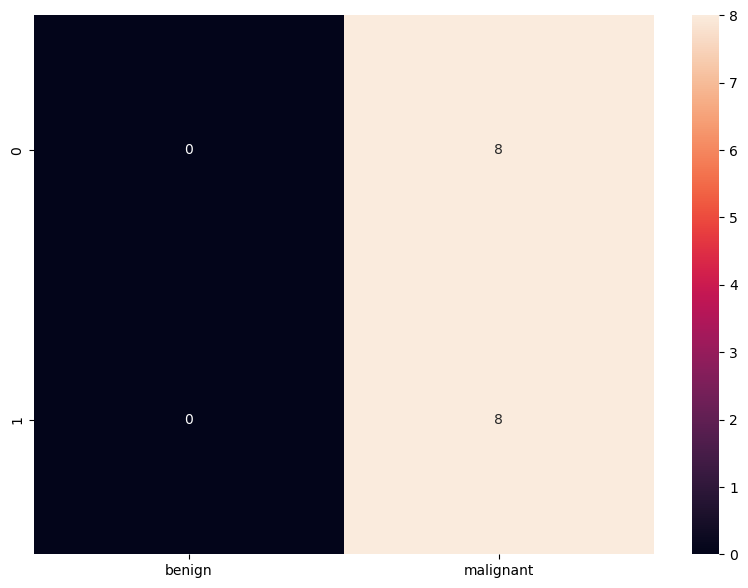

In [76]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

In [ ]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)

export_path

In [64]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [65]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)

    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: benign, file: benign\12.jpg
1/1 [==============================] - 1s 813ms/step
PREDICTED: class: Benign, confidence: 0.865088


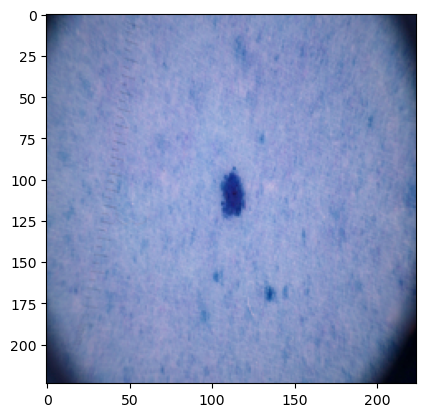

<Figure size 640x480 with 0 Axes>

SOURCE: class: malignant, file: malignant\16.jpg
1/1 [==============================] - 0s 84ms/step
PREDICTED: class: Malignant, confidence: 0.999990


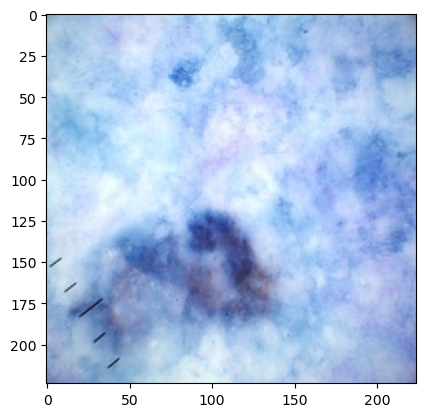

In [66]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

In [67]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

A subdirectory or file tflite_models already exists.


11544160